<CENTER>
</br>
<p><font size="5">  M2MO & EY - Internship </font></p>
<p><font size="5">  Modelling Initial Margin and Counterparty Risk in Uncleared Derivatives </font></p>
<p><font size="4">  SANGLIER Nathan </font></p>
<p><font size="3"></br>May 2025</font></br></div>
<p><span style="color:blue">nathan.sanglier@etu.u-paris.fr</span>
</p>
</CENTER>

## <span id="section-0" style="color:#00B8DE"> 0 - Imports & Parameters </span>

In [ ]:
import  numpy                   as      np
import  matplotlib.pyplot       as      plt
from    scipy.stats             import  norm
from    scipy.special           import  eval_genlaguerre
from    sklearn.linear_model    import  LinearRegression
import  statsmodels.api         as      sm
import  statsmodels.formula.api as      smf
import  pandas                  as      pd

np.random.seed(0)

In [36]:
r           = 0.05
S0          = 100
sigma       = 0.3
T           = 1
delta       = 1/24 # 10 business days, ie. 2 weeks
dt          = 1/240 # 1 business day

time_grid   = np.arange(0, T, dt)
N           = len(time_grid)-1
M           = 5000
tref        = 1/12
ind_tref    = int(tref/dt)
ind_delta   = int(delta/dt)

K           = 95

def beta(t):
    return np.exp(-r*t)

In [37]:
def gen_S():
    paths           = np.zeros((M, N+1))
    paths[:, 0]     = S0
    Z               = np.random.normal(0, 1, size=(M, N))
    increments      = np.exp((r-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
    paths[:, 1:]    = S0 * np.cumprod(increments, axis=1)
    return paths

S_paths = gen_S()

In [38]:
def gen_mtm_put(S_paths):
    M   = S_paths.shape[0]
    mtm = np.zeros((M, N+1))
    for i in range(N+1):
        d1          = (np.log(S_paths[:, i]/K) + (r + 0.5*sigma**2)*(T-time_grid[i])) / (sigma*np.sqrt(T-time_grid[i]))
        d2          = d1 - sigma*np.sqrt(T-time_grid[i])
        mtm[:, i]   = K*beta(T-time_grid[i])*norm.cdf(-d2) - S_paths[:, i]*beta(T-time_grid[i])*norm.cdf(-d1)
    return mtm

mtm_paths       = gen_mtm_put(S_paths)
mtm_diff_paths  = mtm_paths[:, ind_delta:] - mtm_paths[:, :-ind_delta]

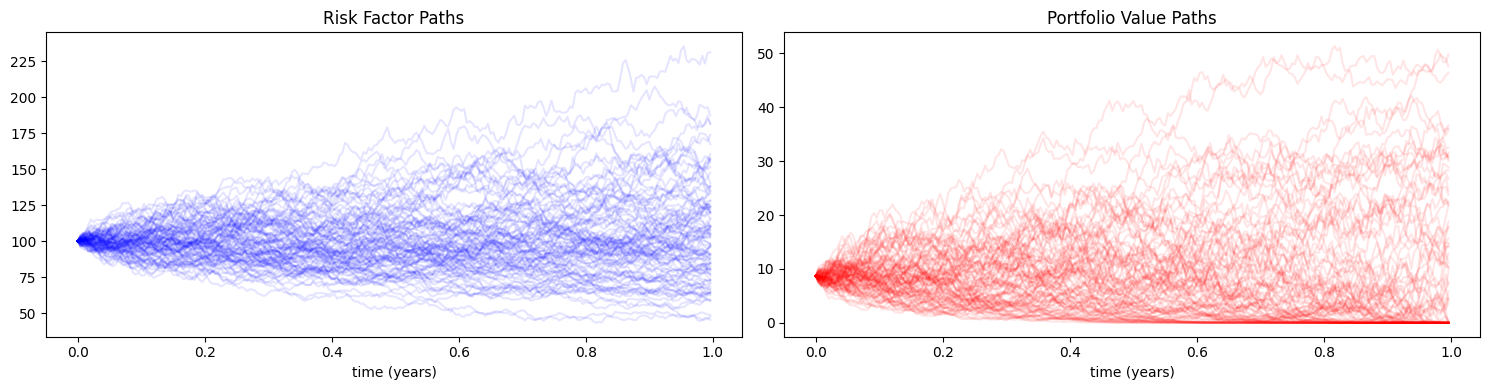

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(time_grid, S_paths[:100, :].T, color='blue', alpha=0.1)
axs[0].set_title('Risk Factor Paths')
axs[0].set_xlabel('time (years)')
axs[1].plot(time_grid, mtm_paths[:100, :].T, color='red', alpha=0.1)
axs[1].set_title('Portfolio Value Paths')
axs[1].set_xlabel('time (years)')
plt.tight_layout()
plt.show()

In [ ]:
S_jlsmc     = 4
S_glsmc     = 2
X_jlsmc     = np.column_stack([eval_genlaguerre(s, 0, mtm_paths[:, ind_tref]) for s in range(S_jlsmc+1)])
X_glsmc     = np.column_stack([mtm_paths[:, ind_tref]**r for r in range(S_glsmc+1)])

mtm_test        = np.linspace(np.min(mtm_paths[:, ind_tref]), np.max(mtm_paths[:, ind_tref]), 1000)
X_test_jlsmc    = np.column_stack([eval_genlaguerre(s, 0, mtm_test) for s in range(S_jlsmc+1)])
X_test_glsmc    = np.column_stack([mtm_test**r for r in range(S_glsmc+1)])

order_mom = 4
y_hat_jlsmc = np.zeros((X_test_jlsmc.shape[0], order_mom+1))
for j in range(1, order_mom+1):
    y = mtm_diff_paths[:, ind_tref]**j
    model = LinearRegression(fit_intercept=False)
    model.fit(X_jlsmc, y)
    y_hat_jlsmc[:, j-1] = model.predict(X_test_jlsmc)

'''
model = LinearRegression(fit_intercept=False)
model.fit(X_glsmc, mtm_diff_paths[:, ind_tref]**2)
y_hat_glsmc = model.predict(X_test_glsmc)
'''

glm = smf.glm(
    formula = "dV ~ V2 + V",
    data    = pd.DataFrame({'dV': Z, 'V': X}),
    family  = sm.families.Gaussian(sm.families.links.log())
).fit()

[[  1.           2.64218572   6.98114537]
 [  1.          12.43867538 154.7206452 ]
 [  1.           5.25677815  27.63371656]
 ...
 [  1.           9.18521377  84.36815198]
 [  1.          13.77080126 189.63496742]
 [  1.           4.41846112  19.52279864]]
[-2.11295125  0.95861282 -0.01623054]


In [44]:
mu1_test_jlsmc = y_hat_jlsmc[:, 0]
mu1_test_glsmc = np.zeros_like(mtm_test)

mu2_test_jlsmc = y_hat_jlsmc[:, 1] - y_hat_jlsmc[:, 0]**2
mu2_test_glsmc = y_hat_glsmc

mu3_test_jlsmc = y_hat_jlsmc[:, 2] - 3*y_hat_jlsmc[:, 0]*y_hat_jlsmc[:, 1] + 2*y_hat_jlsmc[:, 0]**3
mu3_test_glsmc = np.zeros_like(mtm_test)

mu4_test_jlsmc = y_hat_jlsmc[:, 3] - 4*y_hat_jlsmc[:, 0]*y_hat_jlsmc[:, 2] + 6*y_hat_jlsmc[:, 0]**2*y_hat_jlsmc[:, 1] - 3*y_hat_jlsmc[:, 0]**4
mu4_test_glsmc = 3*y_hat_glsmc**2

skew_test_jlsmc = mu3_test_jlsmc / mu2_test_jlsmc**(3/2)
skew_test_glsmc = mu3_test_glsmc / mu2_test_glsmc**(3/2)

print(mu2_test_jlsmc)

kurt_test_jlsmc = mu4_test_jlsmc / mu2_test_jlsmc**2
kurt_test_glsmc = mu4_test_glsmc / mu2_test_glsmc**2

[ 0.70893099  0.71138888  0.71397115  0.71667722  0.71950644  0.72245823
  0.72553196  0.72872702  0.7320428   0.7354787   0.7390341   0.74270838
  0.74650095  0.7504112   0.75443851  0.75858227  0.76284189  0.76721675
  0.77170626  0.77630979  0.78102676  0.78585654  0.79079855  0.79585218
  0.80101682  0.80629188  0.81167674  0.81717082  0.82277352  0.82848422
  0.83430234  0.84022728  0.84625843  0.85239521  0.85863701  0.86498325
  0.87143332  0.87798664  0.8846426   0.89140063  0.89826012  0.90522049
  0.91228115  0.9194415   0.92670096  0.93405895  0.94151486  0.94906813
  0.95671816  0.96446437  0.97230617  0.98024299  0.98827424  0.99639934
  1.00461771  1.01292876  1.02133193  1.02982664  1.0384123   1.04708835
  1.0558542   1.06470929  1.07365303  1.08268487  1.09180422  1.10101052
  1.11030319  1.11968167  1.1291454   1.1386938   1.14832631  1.15804236
  1.1678414   1.17772285  1.18768616  1.19773077  1.20785611  1.21806163
  1.22834677  1.23871098  1.24915369  1.25967436  1

C:\Users\natha\AppData\Local\Temp\ipykernel_38988\4115031801.py:14: RuntimeWarning: invalid value encountered in power
  skew_test_glsmc = mu3_test_glsmc / mu2_test_glsmc**(3/2)


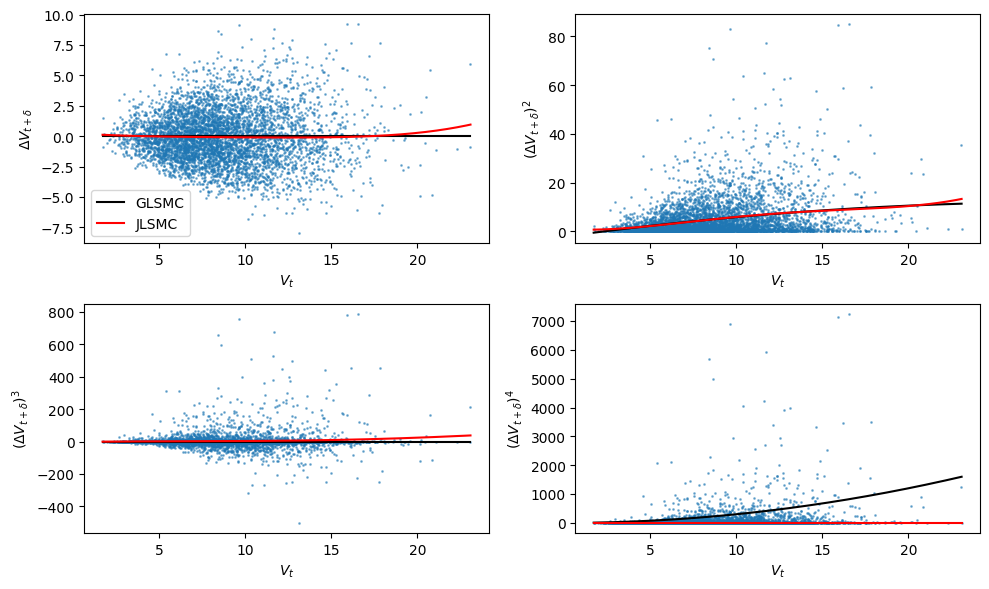

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0, 0].scatter(mtm_paths[:, ind_tref], mtm_diff_paths[:, ind_tref], alpha=0.5, s=1)
axs[0, 0].plot(mtm_test, np.zeros_like(mtm_test), color='black', label='GLSMC')
axs[0, 0].plot(mtm_test, y_hat_jlsmc[:, 0], color='red', label='JLSMC')
axs[0, 0].set_xlabel('$V_t$')
axs[0, 0].set_ylabel('$\\Delta V_{t+\\delta}$')
axs[0, 0].legend()

axs[0, 1].scatter(mtm_paths[:, ind_tref], mtm_diff_paths[:, ind_tref]**2, alpha=0.5, s=1)
axs[0, 1].plot(mtm_test, y_hat_glsmc, color='black', label='GLSMC')
axs[0, 1].plot(mtm_test, y_hat_jlsmc[:, 1], color='red', label='JLSMC')
axs[0, 1].set_xlabel('$V_t$')
axs[0, 1].set_ylabel('$\\left(\\Delta V_{t+\\delta}\\right)^2$')

axs[1, 0].scatter(mtm_paths[:, ind_tref], mtm_diff_paths[:, ind_tref]**3, alpha=0.5, s=1)
axs[1, 0].plot(mtm_test, np.zeros_like(mtm_test), color='black', label='GLSMC')
axs[1, 0].plot(mtm_test, y_hat_jlsmc[:, 2], color='red', label='JLSMC')
axs[1, 0].set_xlabel('$V_t$')
axs[1, 0].set_ylabel('$\\left(\\Delta V_{t+\\delta}\\right)^3$')

axs[1, 1].scatter(mtm_paths[:, ind_tref], mtm_diff_paths[:, ind_tref]**4, alpha=0.5, s=1)
axs[1, 1].plot(mtm_test, 3*mtm_test**2, color='black', label='GLSMC')
axs[1, 1].plot(mtm_test, y_hat_jlsmc[:, 4], color='red', label='JLSMC')
axs[1, 1].set_xlabel('$V_t$')
axs[1, 1].set_ylabel('$\\left(\\Delta V_{t+\\delta}\\right)^4$')

plt.tight_layout()
plt.show()

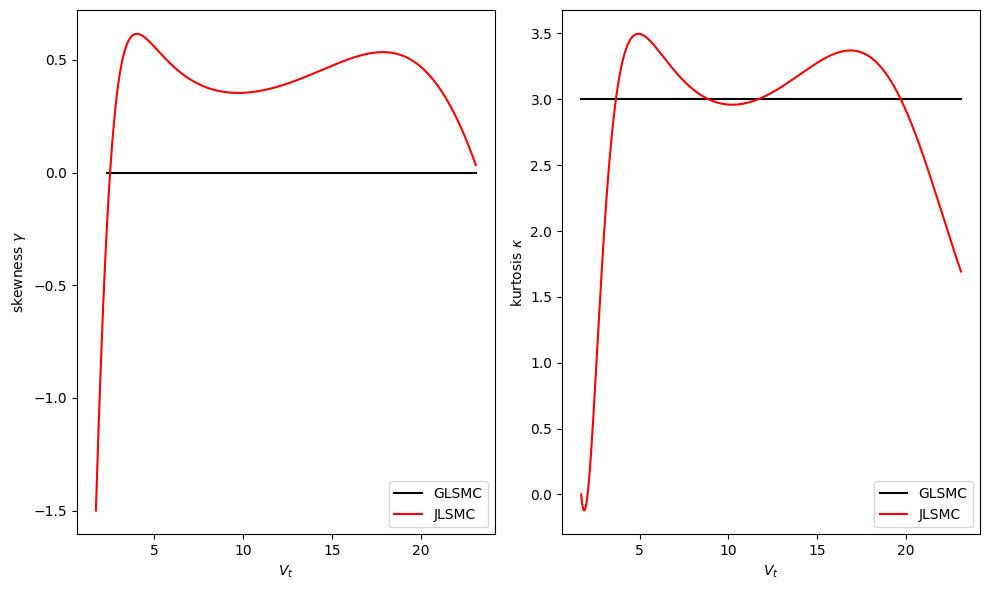

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# skewness plot
axs[0].plot(mtm_test, skew_test_glsmc, color='black', label='GLSMC')
axs[0].plot(mtm_test, skew_test_jlsmc, color='red', label='JLSMC')
axs[0].set_xlabel('$V_t$')
axs[0].set_ylabel('skewness $\\gamma$')
axs[0].legend()

# kurtosis plot
axs[1].plot(mtm_test, kurt_test_glsmc, color='black', label='GLSMC')
axs[1].plot(mtm_test, kurt_test_jlsmc, color='red', label='JLSMC')
axs[1].set_xlabel('$V_t$')
axs[1].set_ylabel('kurtosis $\\kappa$')
axs[1].legend()

plt.tight_layout()
plt.show()